In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

In [2]:
data = pd.read_csv("CreditRiskDataset.csv")
data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


# Data preperation and cleaning

## Convert categorical values to numerical values

In [4]:
# Convert loan_grade to numerical values
ordinal_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
data['loan_grade'] = data['loan_grade'].map(ordinal_mapping)

In [5]:
# Convert cb_person_default_on_file to numerical values
ordinal_mapping = {'Y': 1, 'N': 0}
data['cb_person_default_on_file'] = data['cb_person_default_on_file'].map(ordinal_mapping)

In [6]:
# Convert person_home_ownership to numerical values
ordinal_mapping = {'RENT': 1, 'OWN': 2, 'MORTGAGE': 3, 'OTHER': 4}
data['person_home_ownership'] = data['person_home_ownership'].map(ordinal_mapping)

In [7]:
# Convert loan_intent to numerical values
ordinal_mapping = {'PERSONAL': 1, 'EDUCATION': 2, 'MEDICAL': 3, 'HOMEIMPROVEMENT': 4, 'DEBTCONSOLIDATION': 5, 'VENTURE': 6}
data['loan_intent'] = data['loan_intent'].map(ordinal_mapping)

## Removing missing values

In [8]:
print('Missing values:')
data.isnull().sum()

Missing values:


person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [9]:
#drop missing values 
data = data.dropna()
data.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

## Remove outliers

In [11]:
# Remove outliers in person_age
data = data[data['person_age']<=100]
data.shape

(28634, 12)

In [12]:
# Remove outliers in person_emp_length
# Employment cannot be greater than the individual's age and therefore deduct the childhood
data = data.loc[data['person_emp_length'] < data['person_age'] - 15]
data.shape

(27973, 12)

# Data modeling

## Split dataset

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
# Define target variable (y) and other varibles (X)
y = data['loan_status']
X = data.drop(['loan_status'], axis = 1)

In [16]:
# Split dataset
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

In [17]:
# Show the data split in numbers
shape_dict = {'shape of whole dataset': data.shape, 'shape of train_X': train_X.shape, 'shape of test_X': test_X.shape, 'shape of train_y': train_y.shape, 'shape of test_y': test_y.shape}
for i, v in shape_dict.items(): 
    print(i, v)

shape of whole dataset (27973, 12)
shape of train_X (18741, 11)
shape of test_X (9232, 11)
shape of train_y (18741,)
shape of test_y (9232,)


## SMOTE

In [18]:
from imblearn.over_sampling import SMOTE

In [19]:
# SMOTE with 5 nearest neighbors
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
smote_X, smote_y = sm.fit_resample(train_X, train_y)

In [20]:
smote_y.value_counts()

1    14725
0    14725
Name: loan_status, dtype: int64

# Data modeling

In [23]:
# Load classifiers and split dataset in training and testing
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Fit the classifiers using the training dataset
classifiers = {"RF": {"f": RandomForestClassifier(random_state=42)},
               "DT": {"f": DecisionTreeClassifier(random_state=42)},
               "LR": {"f": LogisticRegression(solver = 'liblinear', random_state=42)}}

for model in classifiers.keys():
    # Fit
    classifiers[model]["f"].fit(smote_X, smote_y)
    # Predict
    classifiers[model]["c"] = classifiers[model]["f"].predict(test_X)
    classifiers[model]["p"] = classifiers[model]["f"].predict_proba(test_X)
    classifiers[model]["p_train"] = classifiers[model]["f"].predict_proba(smote_X)

# Evaluation of the preformance and results

In [24]:
# Evaluate the performance
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
measures = {"f1": f1_score, "pre": precision_score, 
            "rec": recall_score, "acc": accuracy_score}
results = pd.DataFrame(columns=measures.keys())

# Evaluate each model in classifiers
for model in classifiers.keys():
    results.loc[model] = [measures[measure](test_y, classifiers[model]["c"]) for measure in measures.keys()]

results

,f1,pre,rec,acc
RF,0.775186,0.816856,0.737561,0.905004
DT,0.696296,0.644906,0.756585,0.853445
LR,0.535740,0.420322,0.738537,0.715771


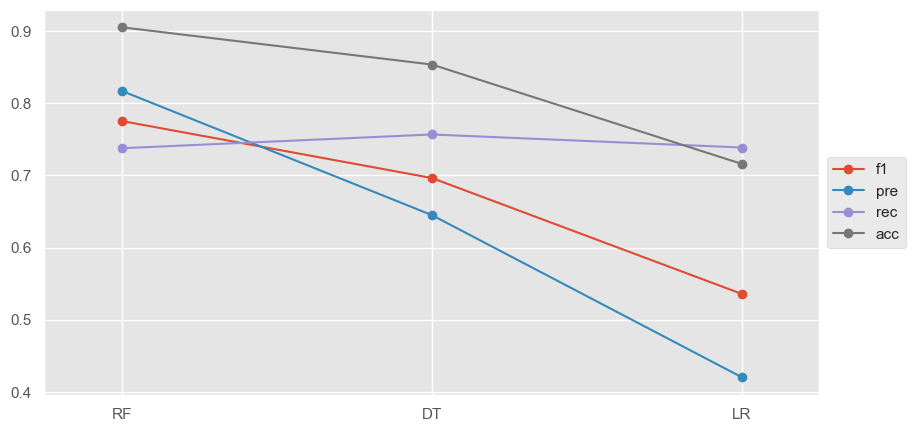

In [25]:
# Plot the results
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
plt.style.use('ggplot')

figsize(10, 5)
ax = plt.subplot(111)

ind = np.arange(results.shape[0])
width = 0.2
l = ax.plot(ind, results, "-o")
plt.legend(iter(l), results.columns.tolist(), loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim([-0.25, ind[-1]+.25])
ax.set_xticks(ind)
ax.set_xticklabels(results.index)
plt.show()